In [218]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
import numpy as np

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [220]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [221]:
IMAGES = './train/images'
MASKS = './train/masks'
classes = './train/_classes.csv'

In [222]:
class UNet(nn.Module):
    
    def __init__(self, n_class):
        super().__init__()
       
        
        """
        Encoder 
        
        Every block in encoder has 2 convolution layer followed by max pooling layer, except last block which do not have max pooling layer
        
        The input to the U-Net is 400*400*channels
        
        """
        
        self.enc_blk11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) 
        self.enc_blk12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.enc_blk21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_blk22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.enc_blk31 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_blk32 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        self.enc_blk41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_blk42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.enc_blk51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc_blk52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        
        
        """
        Decoder
        Here Upsampling of layers are done
        """
        
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_blk11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec_blk12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_blk21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_blk22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_blk31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_blk32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_blk41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_blk42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        
        # Output Layer
        self.out_layer = nn.Conv2d(64, n_class, kernel_size=1)
       
    
    
    def forward(self, x):
        
        # Encoder
        enc11 = self.relu(self.enc_blk11(x))
#         print("Encoder block 1 conv layer 1 ", enc11.shape)
        enc12 = self.relu(self.enc_blk12(enc11))
#         print("Encoder block 1 conv layer 2 ",enc12.shape)
        pool1 = self.pool(enc12)
#         print("Encoder block 1 pooling layer ",pool1.shape)
        
        enc21 = self.relu(self.enc_blk21(pool1))
#         print("Encoder block 2 conv layer 1 ",enc21.shape)
        enc22 = self.relu(self.enc_blk22(enc21))
#         print("Encoder block 2 conv layer 2 ",enc22.shape)
        pool2 = self.pool(enc22)
#         print("Encoder block 2 pooling layer ",pool2.shape)
        
        
        enc31 = self.relu(self.enc_blk31(pool2))
#         print("Encoder block 3 conv layer 1 ",enc31.shape)
        enc32 = self.relu(self.enc_blk32(enc31))
#         print("Encoder block 3 conv layer 2 ",enc32.shape)
        pool3 = self.pool(enc32)
#         print("Encoder block 3 pooling layer ",pool3.shape)
        
        enc41 = self.relu(self.enc_blk41(pool3))
#         print("Encoder block 4 conv layer 1 ", enc41.shape)
        enc42 = self.relu(self.enc_blk42(enc41))
#         print("Encoder block 4 conv layer 2 ", enc42.shape)
        pool4 = self.pool(enc42)
#         print("Encoder block 4 pooling layer ", pool4.shape)
        
        enc51 = self.relu(self.enc_blk51(pool4))
#         print("Encoder block 5 conv layer 1 ", enc51.shape)
        enc52 = self.relu(self.enc_blk52(enc51))
#         print("Encoder block 5 conv layer 2", enc52.shape)
        
        # Decoder
        
        up1 = self.upconv1(enc52)
#         print("Upsampling layer 1 ", up1.shape)
        up11 = torch.cat([up1, enc42], dim=1)
#         print("Upsampled value layer 1 ", up11.shape)
        dec11 = self.relu(self.dec_blk11(up11))
#         print("Decoder block 1 conv layer 1 ", dec11.shape)
        dec12 = self.relu(self.dec_blk12(dec11))
        
#         print("Decoder block 1 conv layer 2", dec12.shape)
        
        up2 = self.upconv2(dec12)
#         print("Upsampling layer 2 ", up2.shape)
        up22 = torch.cat([up2, enc32], dim=1)
#         print("Upsampled value layer 2 ", up22.shape)
        dec21 = self.relu(self.dec_blk21(up22))
#         print("Decoder block 2 conv layer 1 ", dec21.shape)
        dec22 = self.relu(self.dec_blk22(dec21))
#         print("Decoder block 2 conv layer 2 ", dec22.shape)
        
        up3 = self.upconv3(dec22)
#         print("Upsampling layer 3 ", up3.shape)
        up33 = torch.cat([up3, enc22], dim=1)
#         print("Upsampled value layer 3 ", up33.shape)
        dec31 = self.relu(self.dec_blk31(up33))
#         print("Decoder block 3 conv layer 1 ", dec31.shape)
        dec32 = self.relu(self.dec_blk32(dec31))
#         print("Decoder block 3 conv layer 2 ", dec32.shape)
        
        up4 = self.upconv4(dec32)
#         print("Upsampling layer 4 ", up4.shape)
        up44 = torch.cat([up4, enc12], dim=1)
#         print("Upsampled value layer 4 ", up44.shape)
        dec41 = self.relu(self.dec_blk41(up44))
#         print("Decoder block 4 conv layer 1 ", dec41.shape)
        dec42 = self.relu(self.dec_blk42(dec41))
#         print("Decoder block 4 conv layer 2 ", dec42.shape)
        
        out = self.out_layer(dec42)
#         print('Output ', out.shape)
       
        
        return out

In [223]:
class porosity_Dataset(Dataset):
    def __init__(self, image_path, mask_path, x, mean, std, transform=None, patch=False,
                 image_ext=".jpg", mask_ext=".png"):
        self.img_path = image_path
        self.mask_path = mask_path
        self.x = x  # list of base filenames (without extension)
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch
        self.image_ext = image_ext
        self.mask_ext = mask_ext
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        image_filename = self.x[idx] + self.image_ext
        mask_filename = self.x[idx] + "_mask" + self.mask_ext

        img_path = os.path.join(self.img_path, image_filename)
        mask_path = os.path.join(self.mask_path, mask_filename)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if img.shape[:2] != mask.shape[:2]:
            mask = cv2.resize(mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        # else img is numpy array from cv2 already

        img = Image.fromarray(img)
        t = T.Compose([
            T.ToTensor(),
            T.Normalize(self.mean, self.std)
        ])
        img = t(img)

        mask = torch.tensor(mask, dtype=torch.long)  # convert to tensor explicitly

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask, threshold=0.01):
        size = 256
        img_patches = img.unfold(1, size, size).unfold(2, size, size)
        img_patches = img_patches.contiguous().view(3, -1, size, size)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, size, size).unfold(1, size, size)
        mask_patches = mask_patches.contiguous().view(-1, size, size)

        keep_indices = []
        for i, patch in enumerate(mask_patches):
            fg = (patch != 0).sum().item()
            ratio = fg / (size * size)
            if ratio > threshold:
                keep_indices.append(i)

        if not keep_indices:
            keep_indices = [0]  # Always return at least one tile

        return img_patches[keep_indices], mask_patches[keep_indices]

In [224]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


In [225]:
x_all = sorted([os.path.splitext(f)[0] for f in os.listdir(IMAGES)])

In [226]:
# Step 1: Train+Val and Test split
x_temp, x_test = train_test_split(x_all, test_size=0.10, random_state=42, shuffle=True)

# Step 2: Train and Val split from the remaining
x_train, x_val = train_test_split(x_temp, test_size=0.10, random_state=42, shuffle=True)


In [227]:
train_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_train,
    mean=mean,
    std=std,
    transform=t_train,
    patch=True,
    image_ext=".jpg",   # images are .jpg
    mask_ext=".png"     # masks are .png
)

val_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_val,
    mean=mean,
    std=std,
    transform=t_val,
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)
test_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_test,
    mean=mean,
    std=std,
    transform=t_val,  # You can use the same val transforms for test
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)



In [228]:
def custom_collate(batch):
    # batch is a list of tuples (image_tiles, mask_tiles)
    # Here, image_tiles and mask_tiles can be tensors of variable shapes
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return images, masks

In [229]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [230]:
def colorize(mask_tensor, class_colors):
    """Convert class index tensor to RGB image using color map."""
    mask_np = mask_tensor.numpy().astype(np.uint8)
    mask_np[mask_np >= len(class_colors)] = 0  # Avoid out-of-bounds
    color_map = np.array(class_colors, dtype=np.uint8)
    rgb_mask = color_map[mask_np]
    return rgb_mask


In [231]:
def visualize_prediction_sample(image, mask, output, n_classes=11, class_colors=None):
    import matplotlib.pyplot as plt

    pred = torch.argmax(F.softmax(output.unsqueeze(0), dim=1), dim=1).squeeze(0)

    image_np = image.permute(1, 2, 0).numpy()
    image_np = np.clip((image_np * np.array([0.229, 0.224, 0.225]) + 
                        np.array([0.485, 0.456, 0.406])), 0, 1)

    mask_rgb = colorize(mask, class_colors)
    pred_rgb = colorize(pred, class_colors)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[0].axis('off')

    axs[1].imshow(mask_rgb)
    axs[1].set_title("Ground Truth")
    axs[1].axis('off')

    axs[2].imshow(pred_rgb)
    axs[2].set_title("Prediction")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


In [232]:
train_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_train,
    mean=mean,
    std=std,
    transform=t_train,
    patch=True,
    image_ext=".jpg",   # images are .jpg
    mask_ext=".png"     # masks are .png
)

val_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_val,
    mean=mean,
    std=std,
    transform=t_val,
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)
test_dataset = porosity_Dataset(
    image_path=IMAGES,
    mask_path=MASKS,
    x=x_test,
    mean=mean,
    std=std,
    transform=t_val,  # You can use the same val transforms for test
    patch=True,
    image_ext=".jpg",
    mask_ext=".png"
)



In [233]:
def custom_collate(batch):
    # batch is a list of tuples (image_tiles, mask_tiles)
    # Here, image_tiles and mask_tiles can be tensors of variable shapes
    images = [item[0] for item in batch]
    masks = [item[1] for item in batch]
    return images, masks

In [234]:
batch_size = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)


In [235]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=5):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)
        
        iou_per_class = []
        for classes in range(0, n_classes):
            true_class = (pred_mask == classes)
            true_label = (mask == classes)
            
            if true_label.long().sum().item() == 0:
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [236]:
def save_visual_sample(image, mask, output, n_classes, class_colors, save_path):
    # Convert tensors to cpu before numpy
    image = image.cpu().numpy().transpose(1, 2, 0)  # assuming CHW format
    mask_np = mask.cpu().numpy()

    def decode_mask(mask_np):
        color_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
        for cls_idx in range(n_classes):
            color = class_colors[cls_idx]
            color_mask[mask_np == cls_idx] = color
        return color_mask

    # Un-normalize image
    image = np.clip((image * np.array([0.229, 0.224, 0.225]) + 
                     np.array([0.485, 0.456, 0.406])), 0, 1)

    pred_mask = torch.argmax(F.softmax(output.unsqueeze(0), dim=1), dim=1).squeeze(0).cpu().numpy()

    mask_color = decode_mask(mask_np)
    pred_color = decode_mask(pred_mask)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask_color)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred_color)
    axs[2].set_title('Prediction')

    for ax in axs:
        ax.axis('off')

    plt.savefig(save_path)
    plt.close()


In [237]:
class_colors = [
    (0, 0, 0),        # Background
    (255, 0, 0),      # Class 1
    (0, 255, 0),      # Class 2
    (0, 0, 255),      # Class 3
    (255, 255, 0),    # Class 4
    (255, 0, 255),    # Class 5
    (0, 255, 255),    # Class 6
    (128, 128, 0),    # Class 7
    (128, 0, 128),    # Class 8
    (0, 128, 128),    # Class 9
    (192, 192, 192)   # Class 10
]

In [238]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum() / float(correct.numel()))
    return accuracy


In [239]:
def evaluate(model_path, test_loader, device, patch=True, visualize=False, num_visuals=5, n_classes=11, class_colors=None, save_dir=None):
    model = UNet(n_classes)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    test_iou = 0.0
    test_accuracy = 0.0
    total_tiles = 0
    visual_count = 0

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with torch.no_grad():
        for idx, data in enumerate(tqdm(test_loader, desc="Evaluating")):
            image_tiles, mask_tiles = data

            if patch:
                images = torch.cat(image_tiles, dim=0).to(device)
                masks = torch.cat(mask_tiles, dim=0).to(device)
            else:
                images = image_tiles.to(device)
                masks = mask_tiles.to(device)

            if masks.dim() == 4 and masks.size(1) == n_classes:
                masks = torch.argmax(masks, dim=1)

            outputs = model(images)
            
            # Get predicted classes (assume outputs are logits)
            preds = torch.argmax(outputs, dim=1)

            test_iou += mIoU(outputs, masks)

            # Calculate pixel accuracy including background class (usually class 0)
            correct_pixels = (preds == masks).sum().item()
            total_pixels = torch.numel(masks)
            batch_accuracy = correct_pixels / total_pixels
            test_accuracy += batch_accuracy

            total_tiles += 1  # counting batches, not tiles, since we compute accuracy per batch

            if visualize and visual_count < num_visuals:
                for i in range(min(len(images), num_visuals - visual_count)):
                    visualize_prediction_sample(
                        images[i].cpu(),
                        masks[i].cpu(),
                        outputs[i].cpu(),
                        n_classes=n_classes,
                        class_colors=class_colors
                    )

                    # Optional: Save visuals
                    if save_dir:
                        fig_path = os.path.join(save_dir, f"visual_{visual_count}.png")
                        save_visual_sample(images[i], masks[i], outputs[i], n_classes, class_colors, fig_path)

                    visual_count += 1
                    if visual_count >= num_visuals:
                        break

    print(f"Test mIoU: {test_iou / total_tiles:.3f}")
    print(f"Test Accuracy (including background): {test_accuracy / total_tiles:.3f}")

Evaluating:   0%|          | 0/30 [00:00<?, ?it/s]

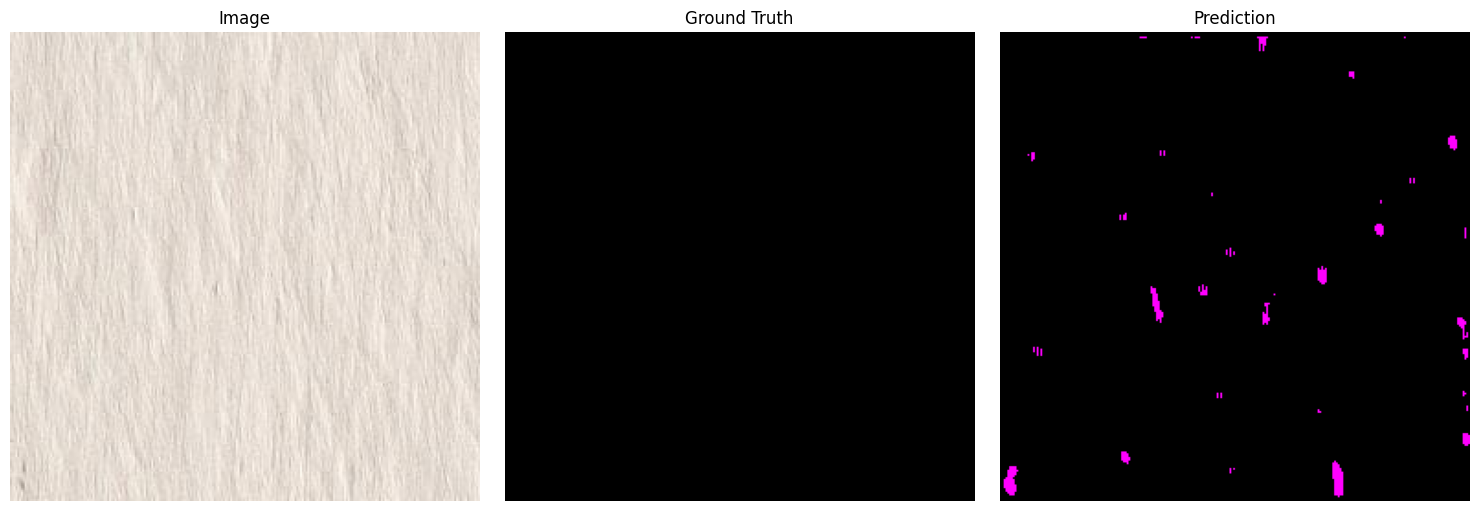

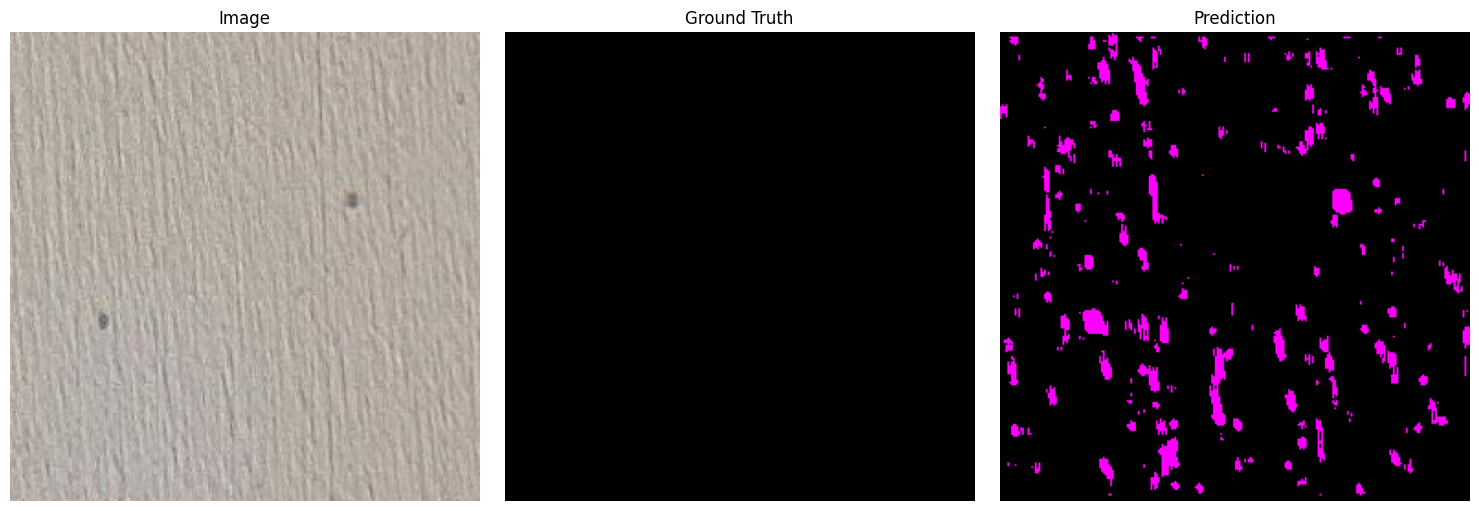

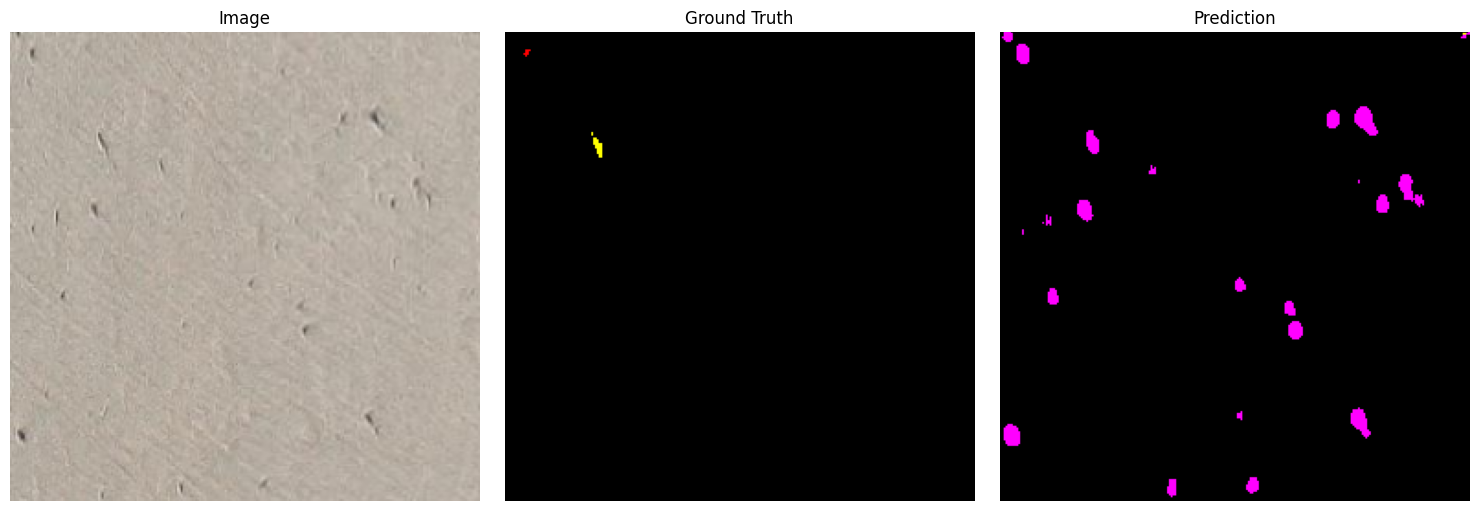

Evaluating:   3%|▎         | 1/30 [00:01<00:56,  1.95s/it]

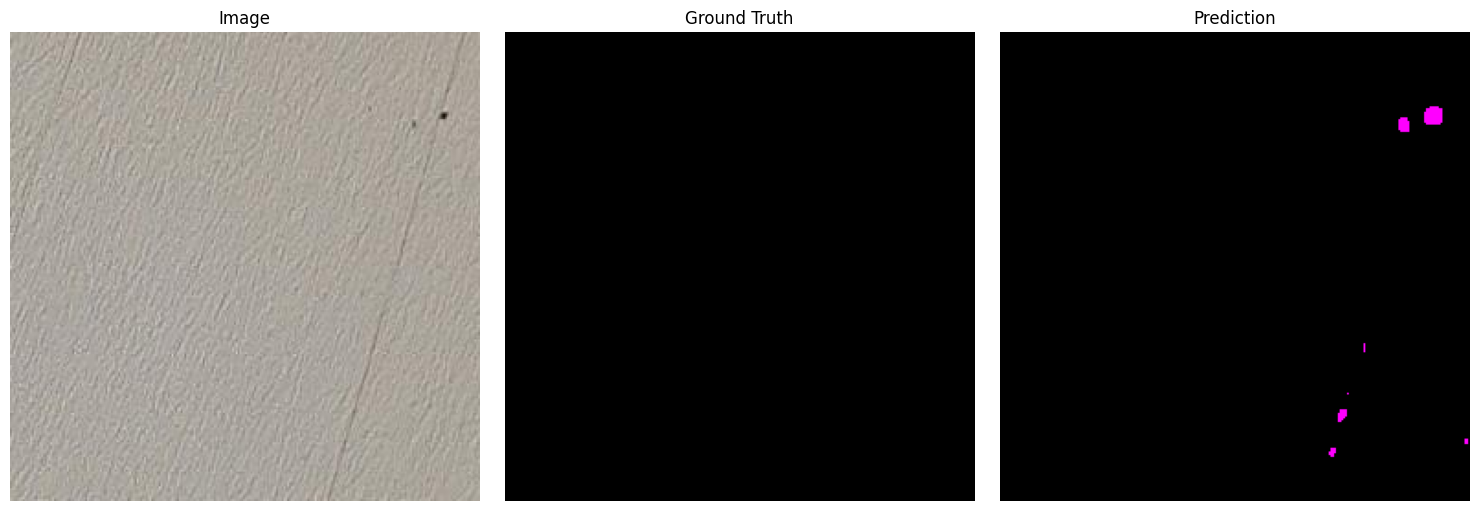

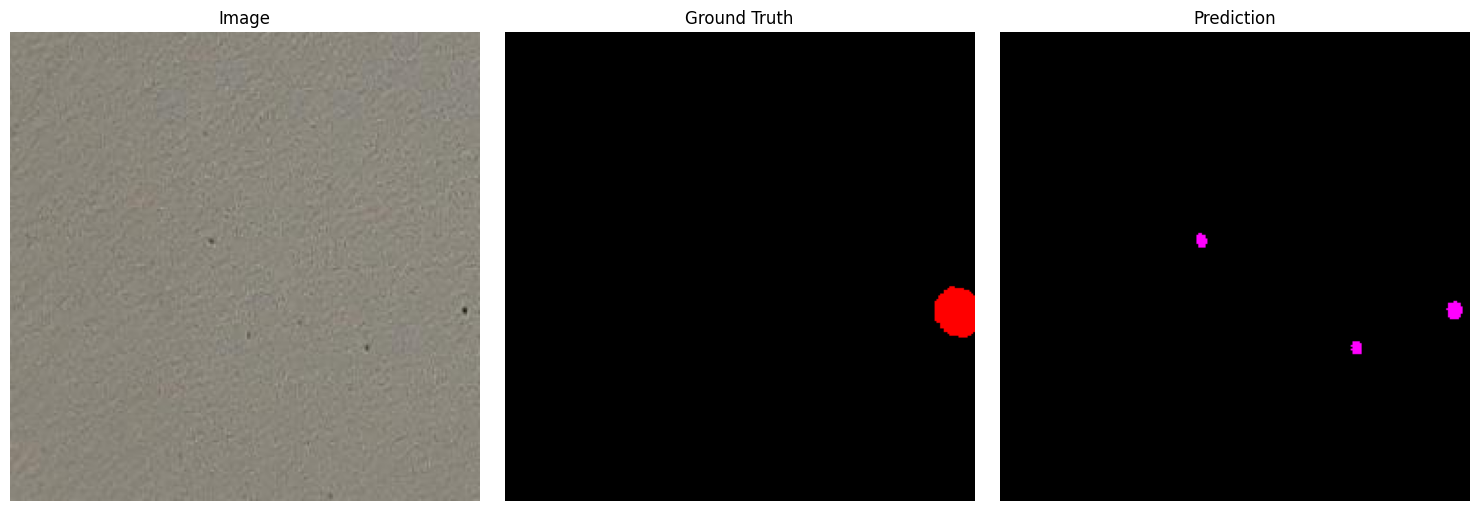

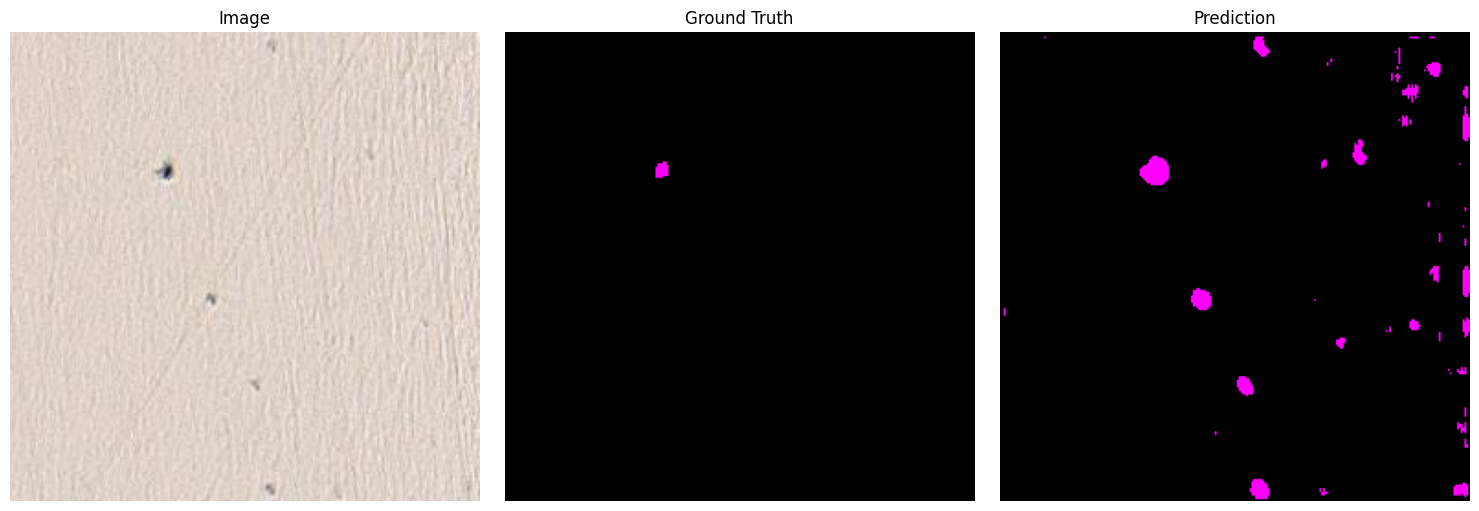

Evaluating:   7%|▋         | 2/30 [00:04<00:56,  2.03s/it]

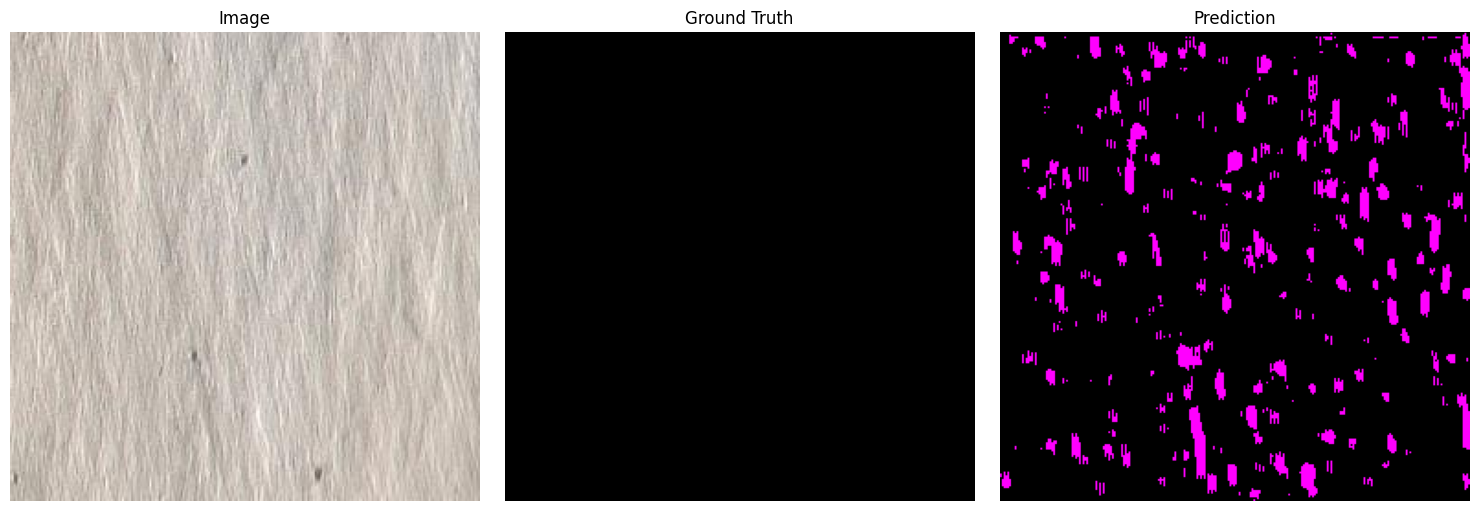

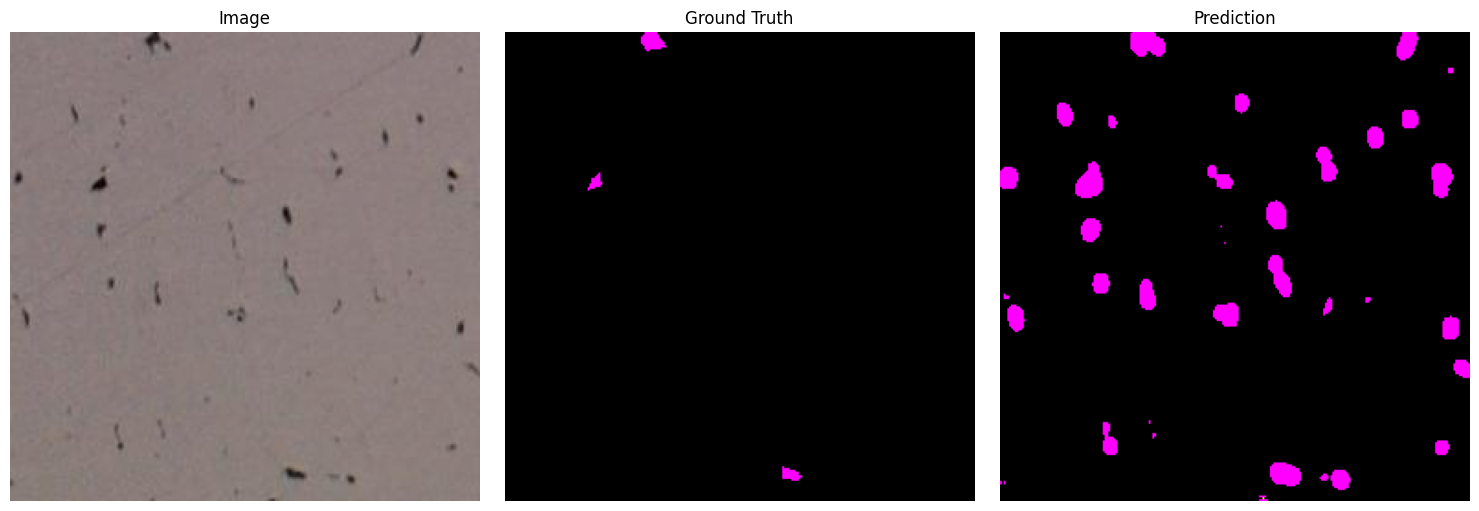

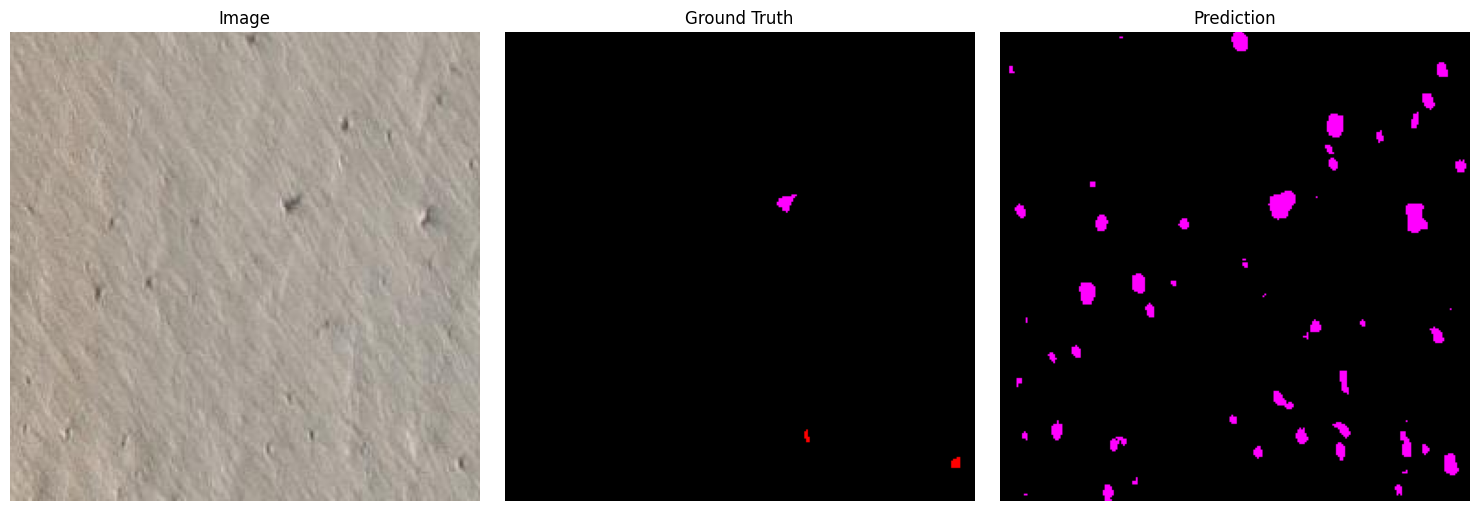

Evaluating:  10%|█         | 3/30 [00:06<00:57,  2.14s/it]

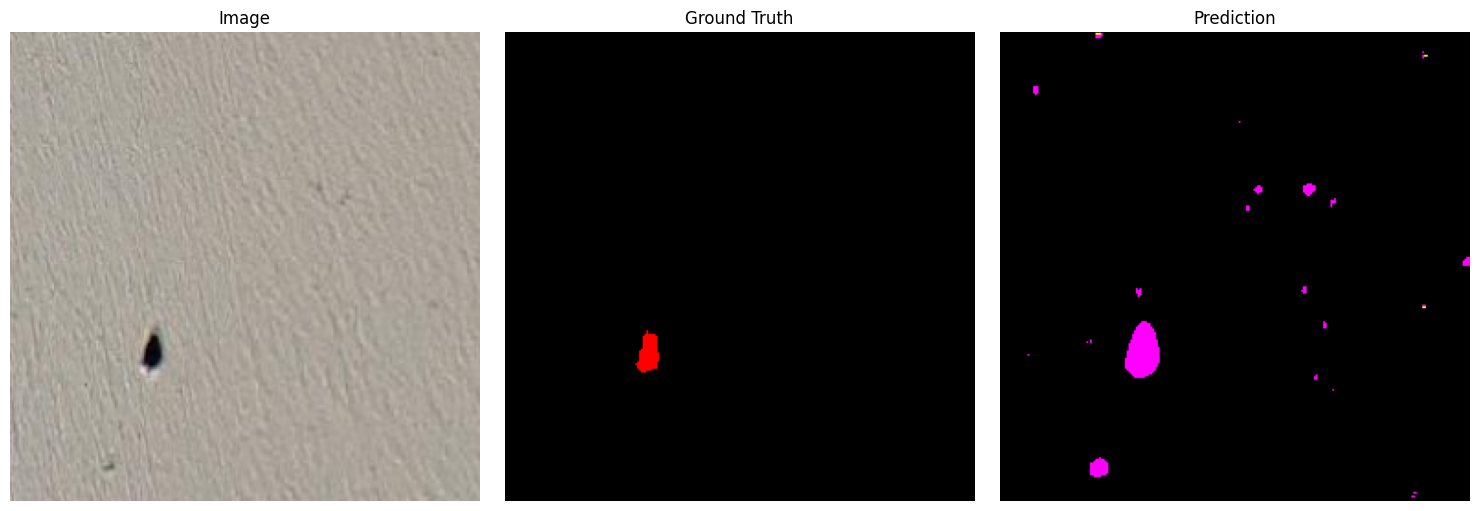

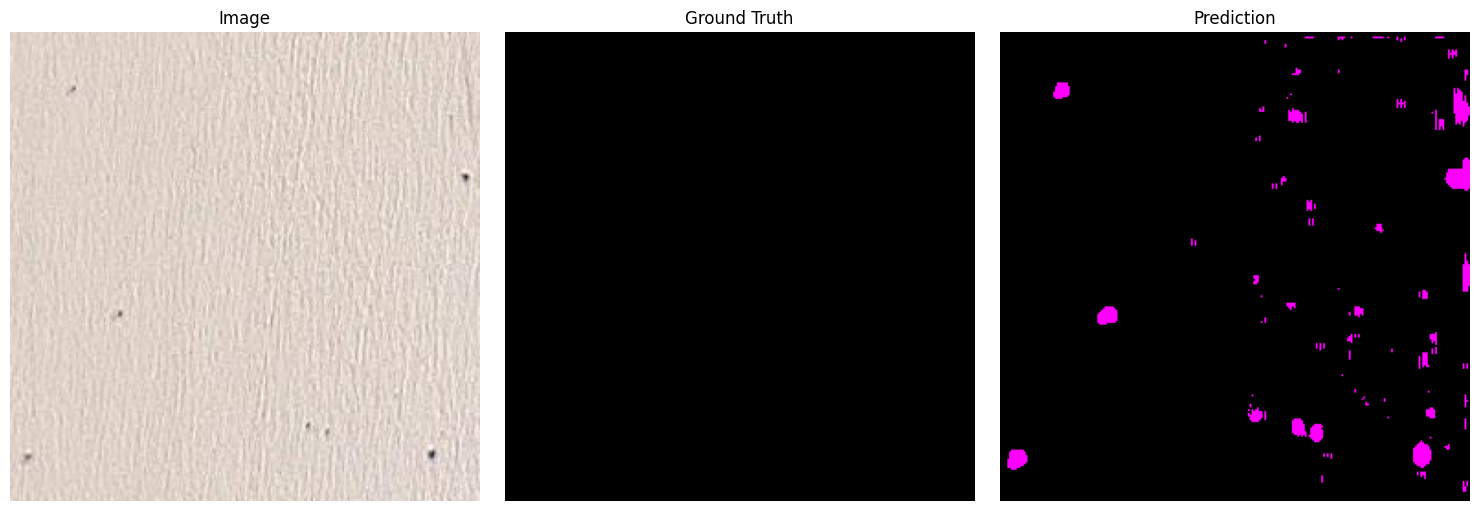

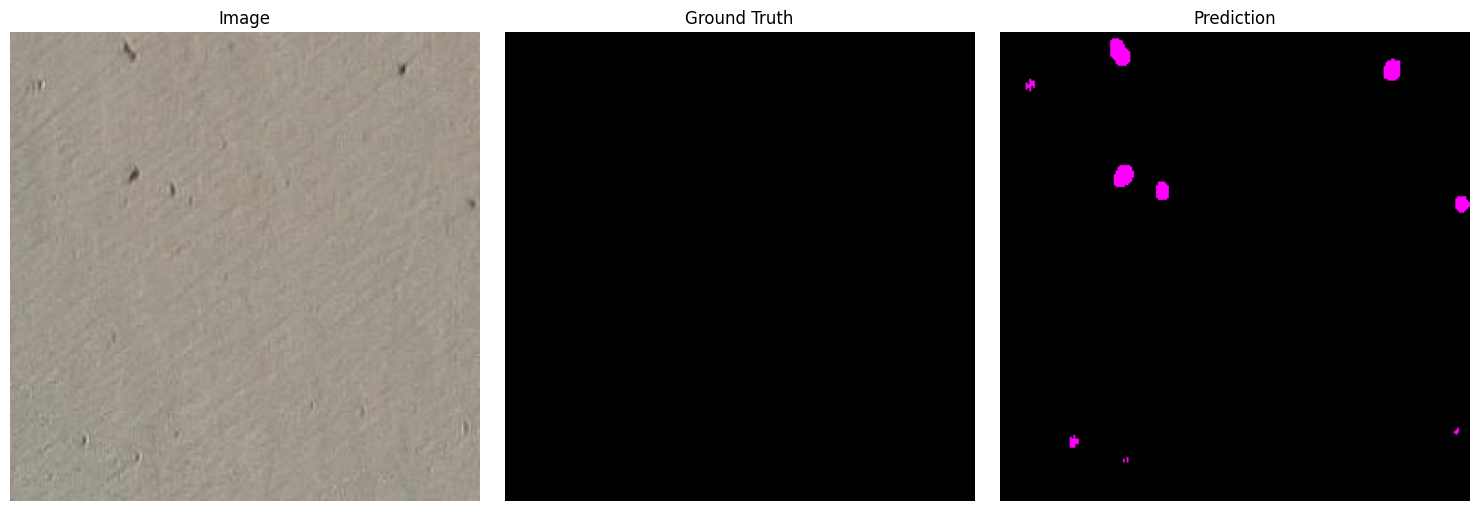

Evaluating:  13%|█▎        | 4/30 [00:08<00:58,  2.25s/it]

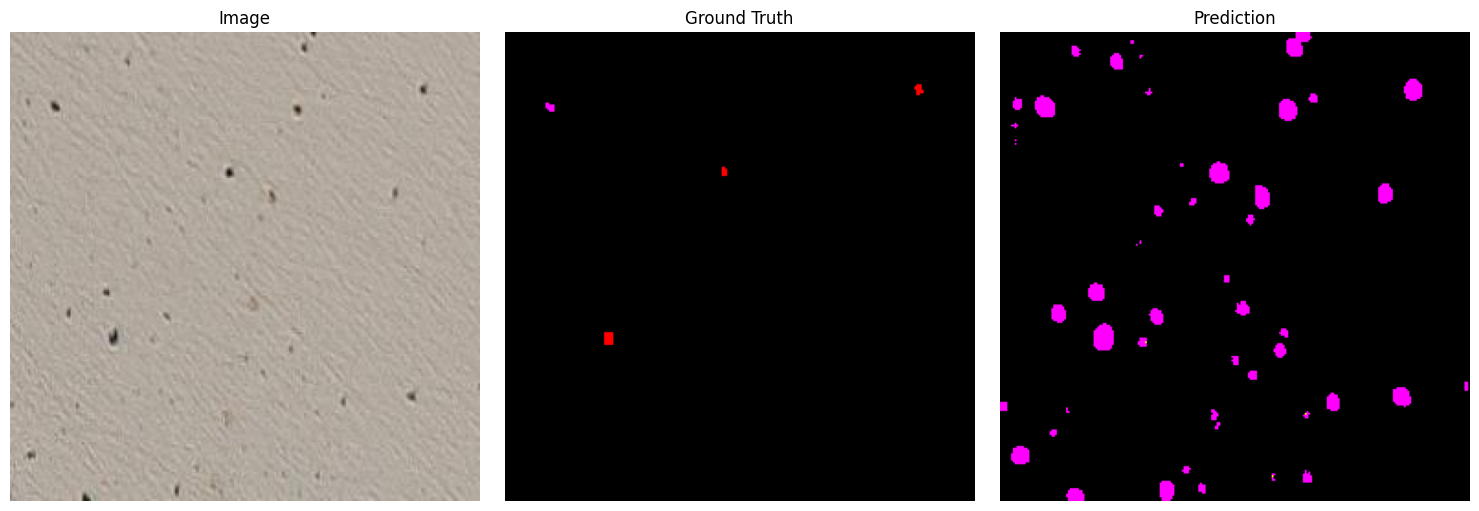

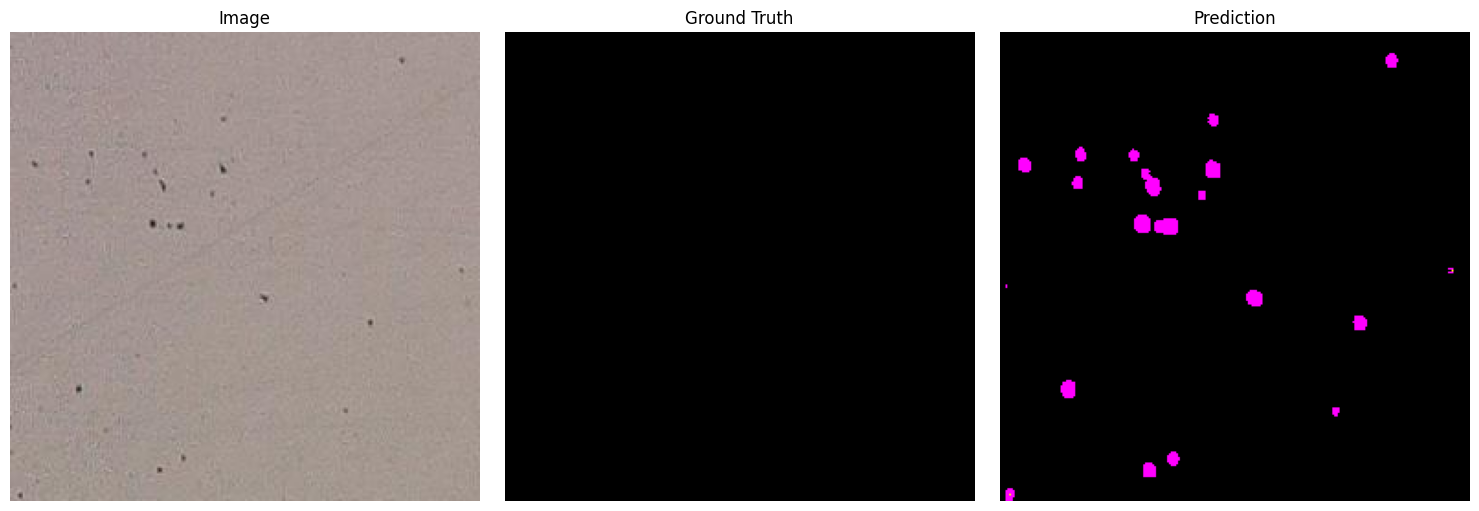

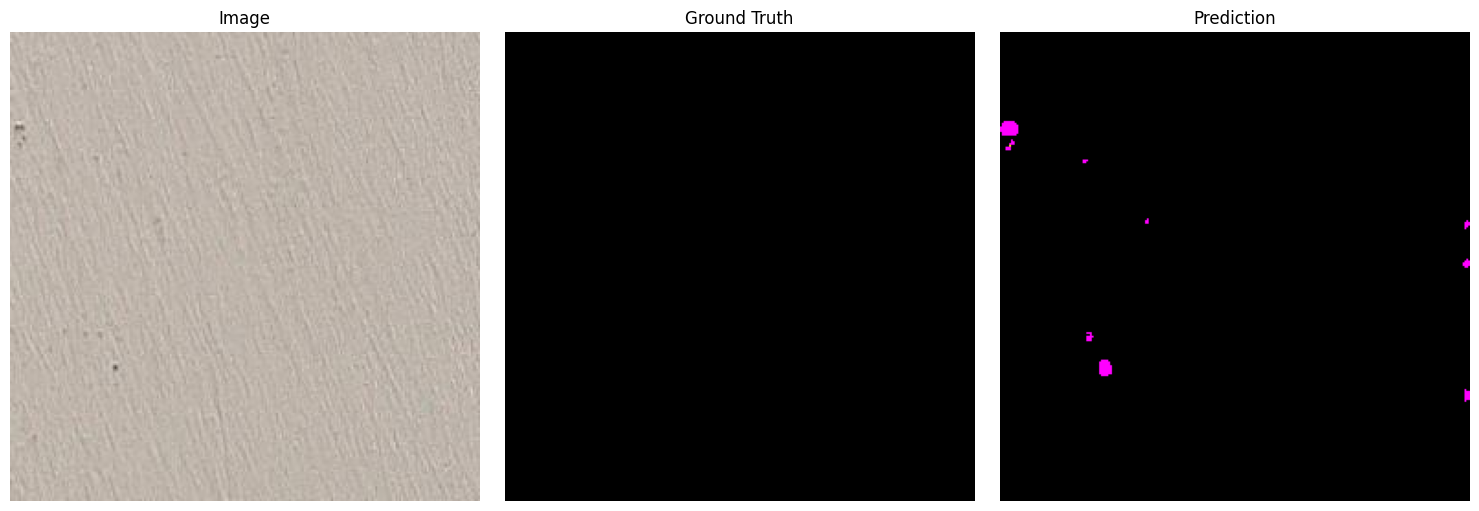

Evaluating:  17%|█▋        | 5/30 [00:11<00:57,  2.29s/it]

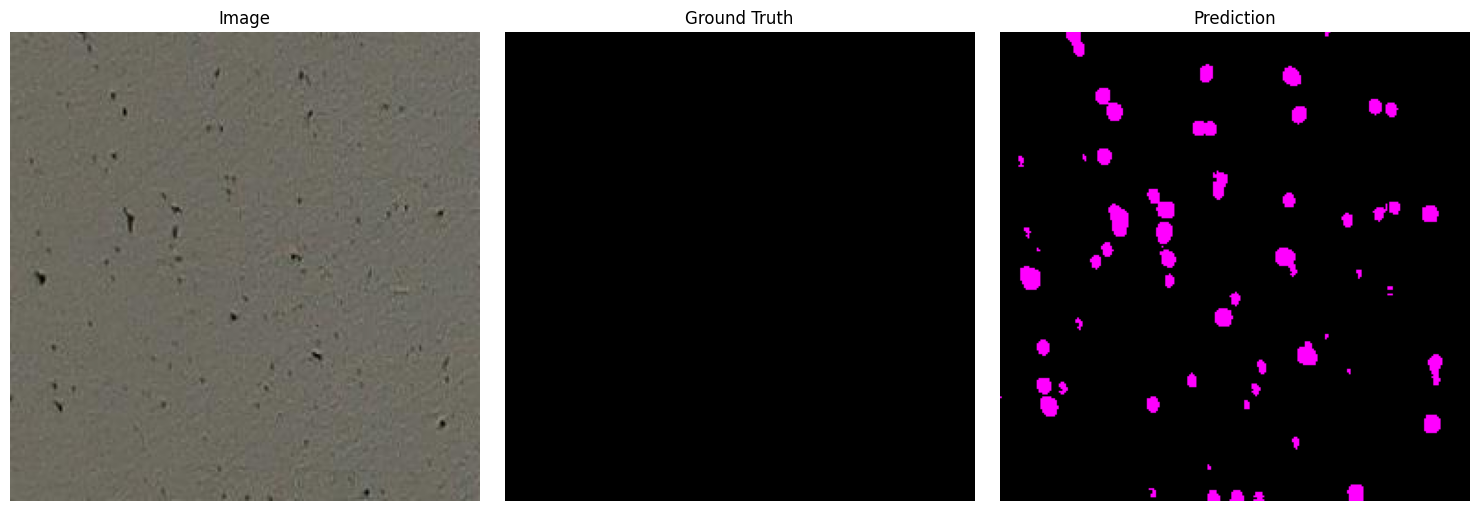

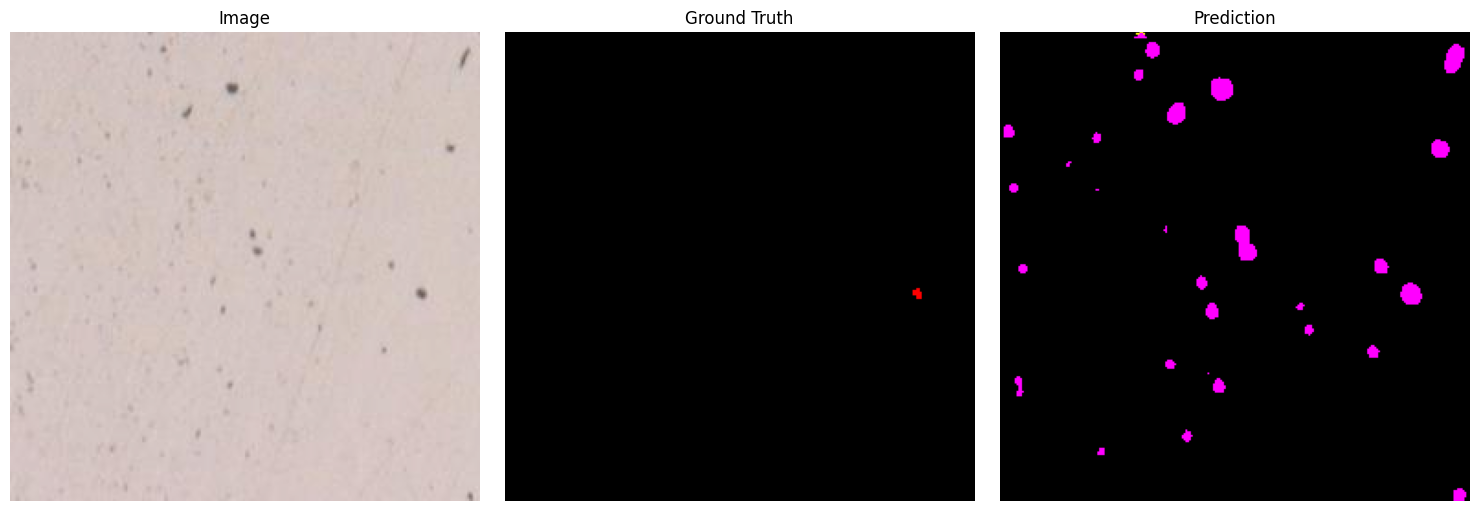

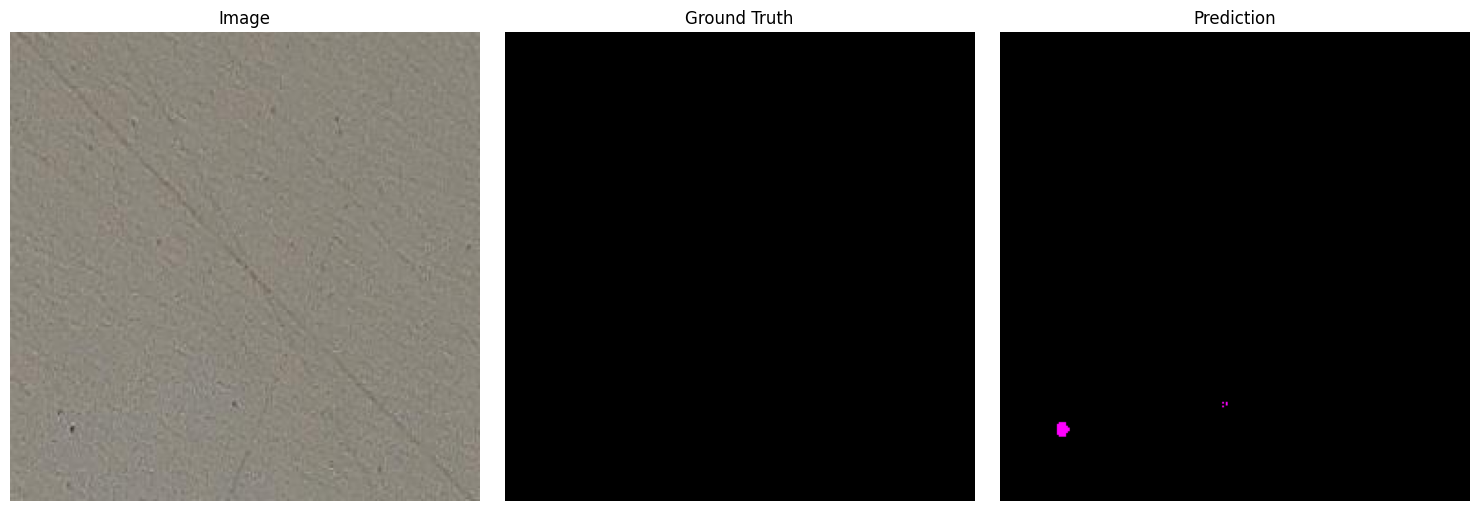

Evaluating:  20%|██        | 6/30 [00:13<00:54,  2.28s/it]

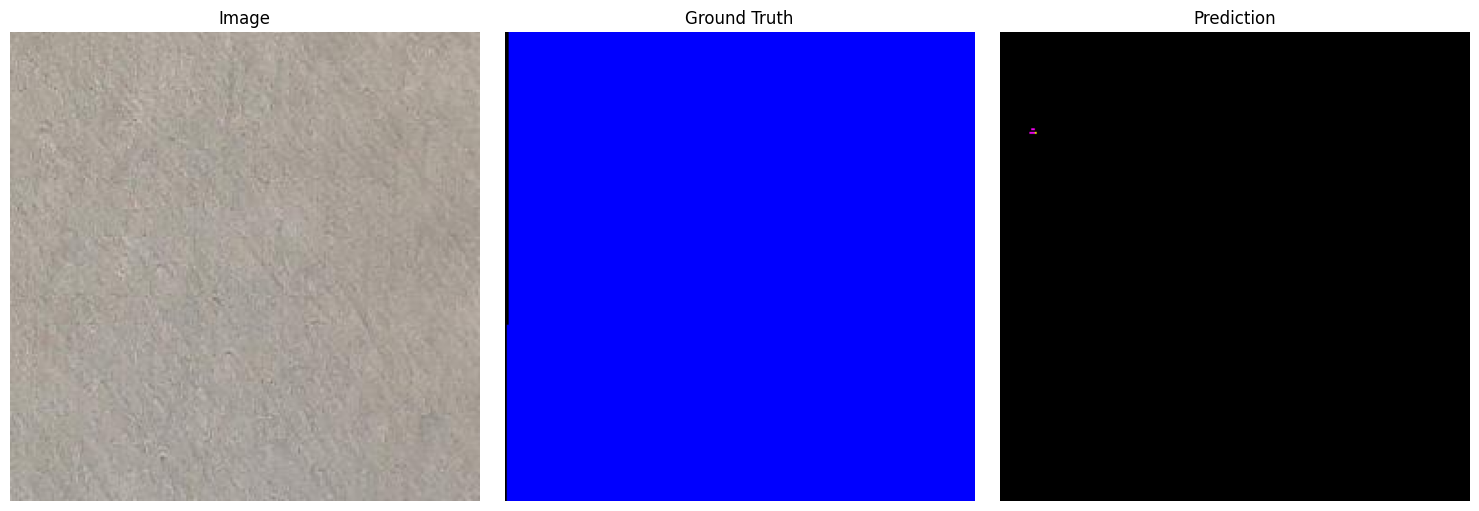

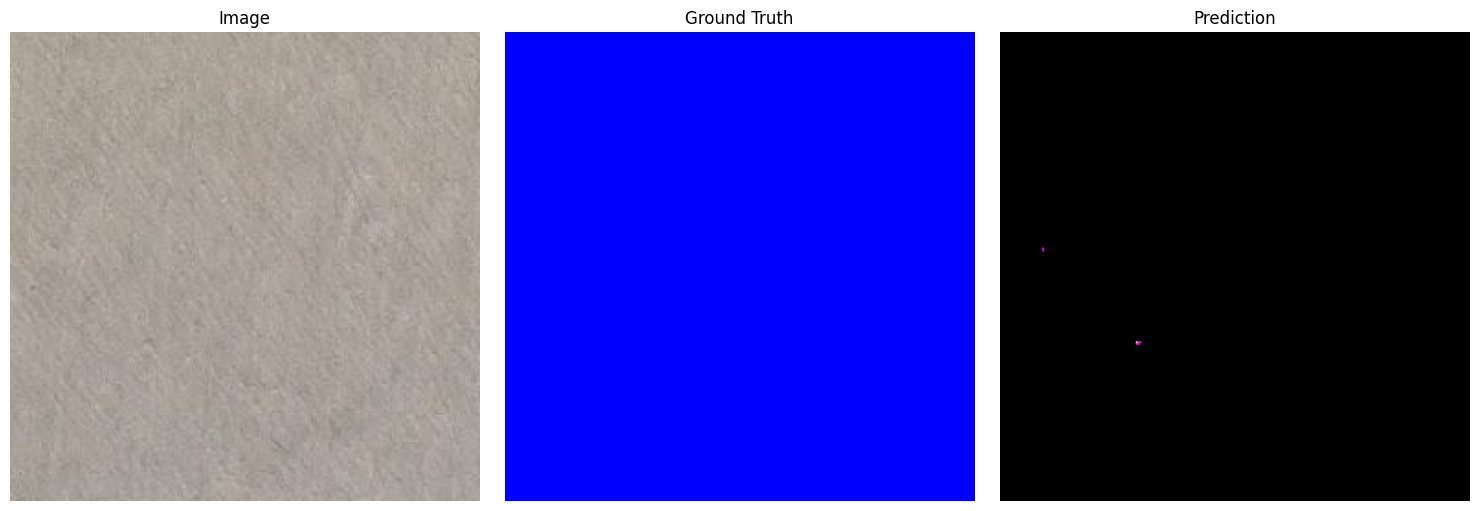

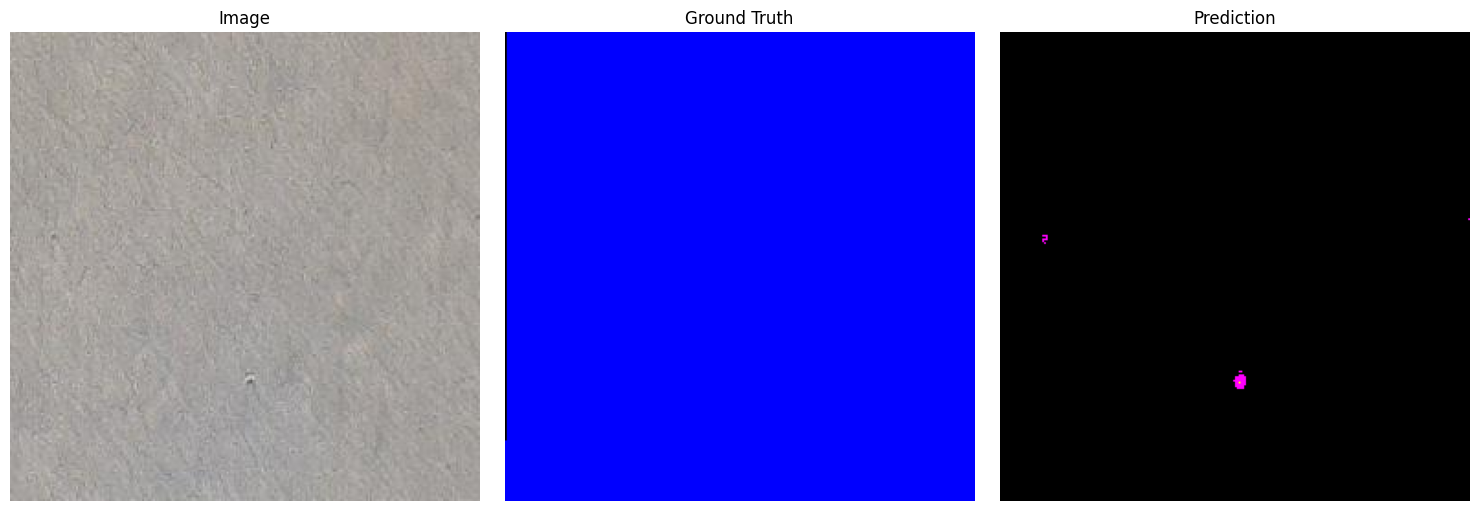

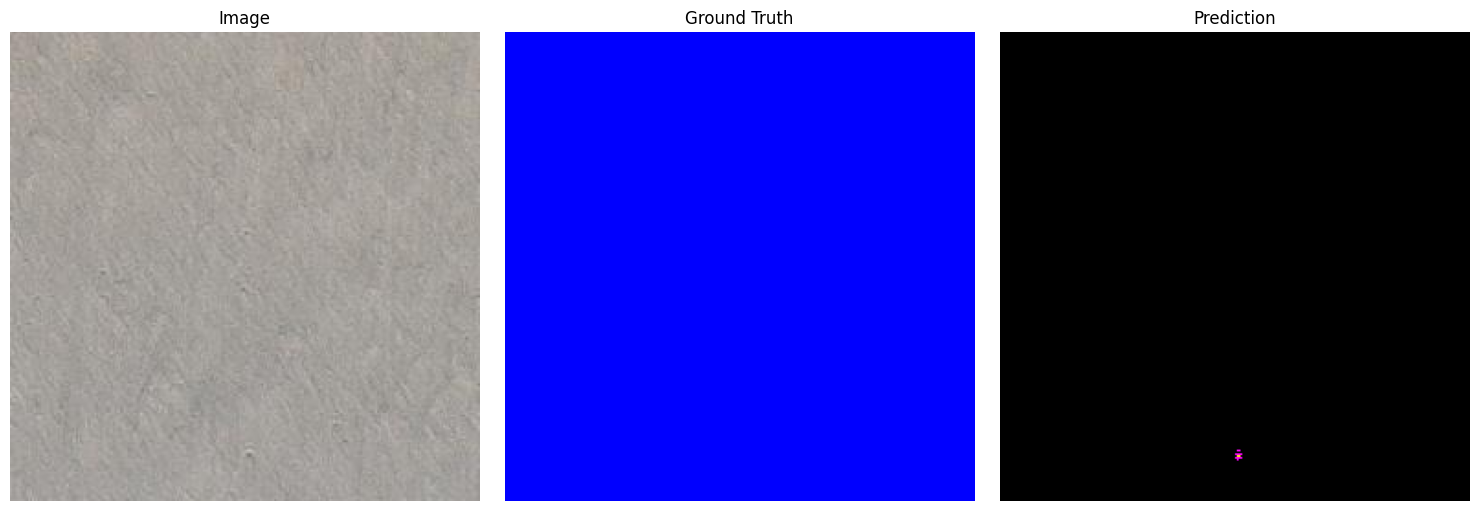

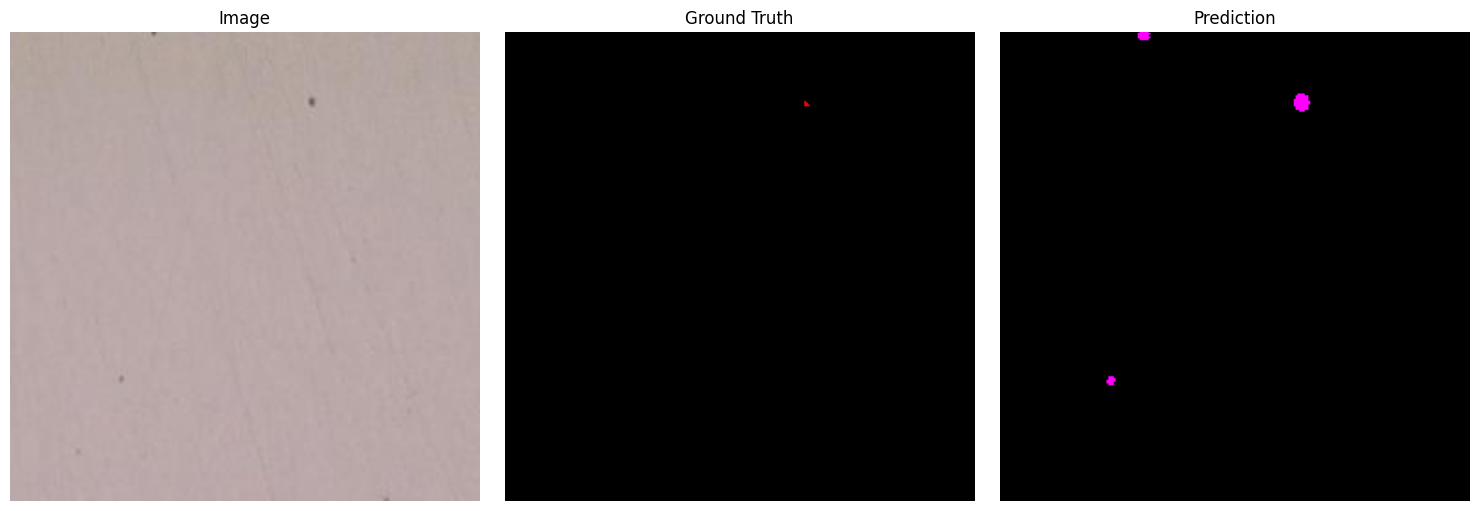

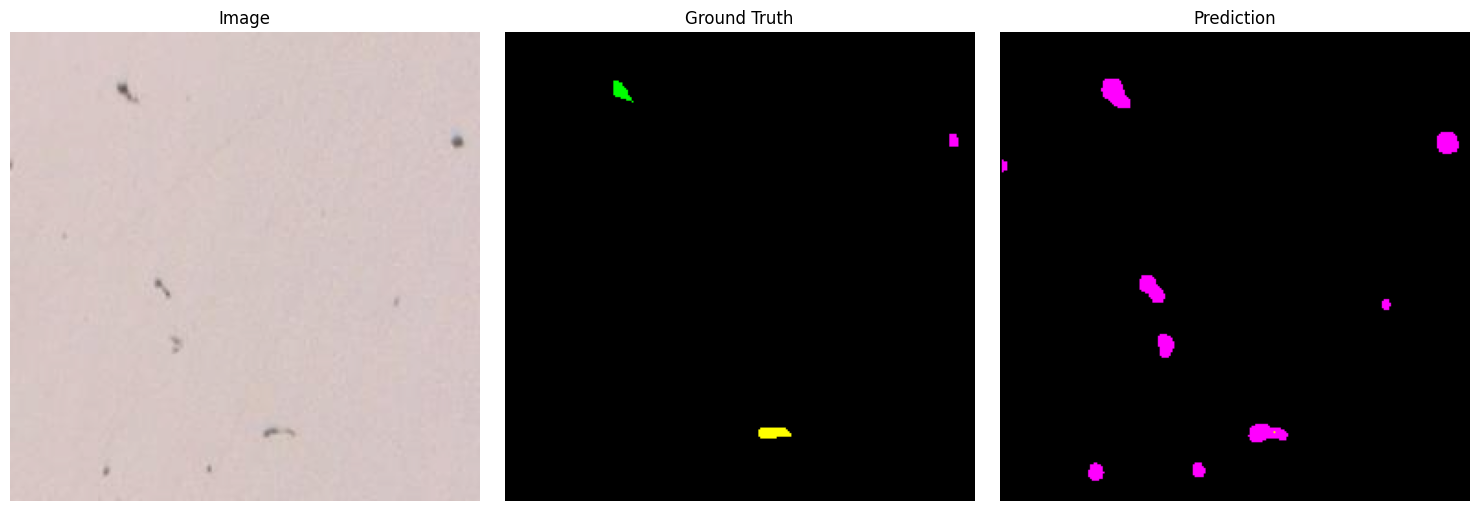

Evaluating:  23%|██▎       | 7/30 [00:17<01:10,  3.05s/it]

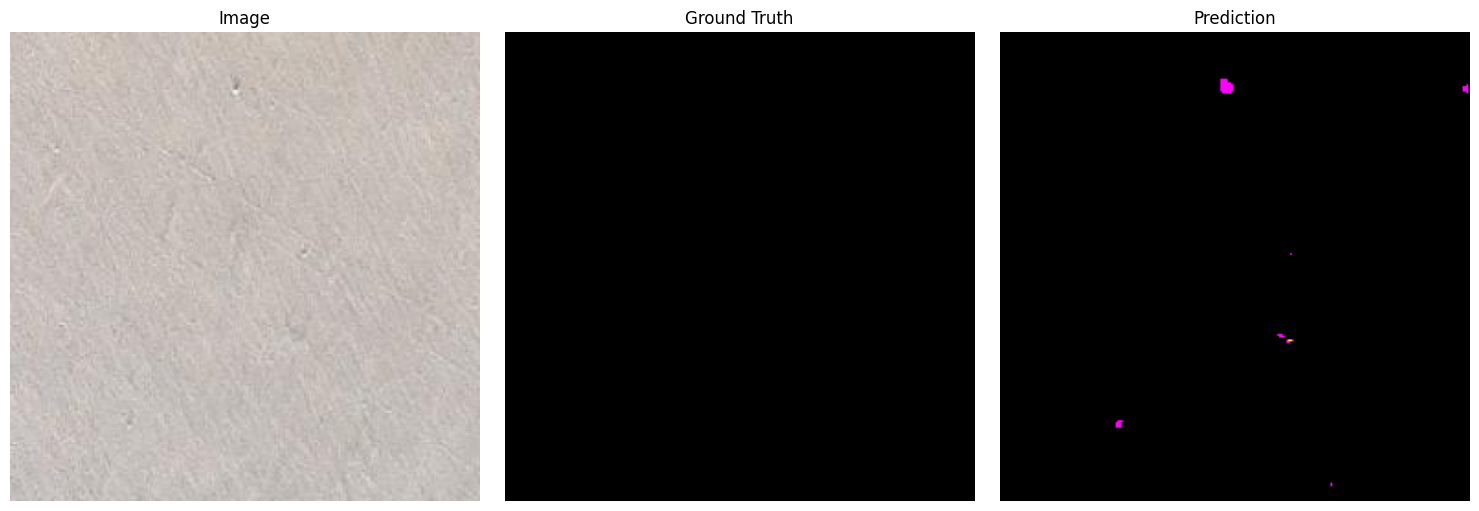

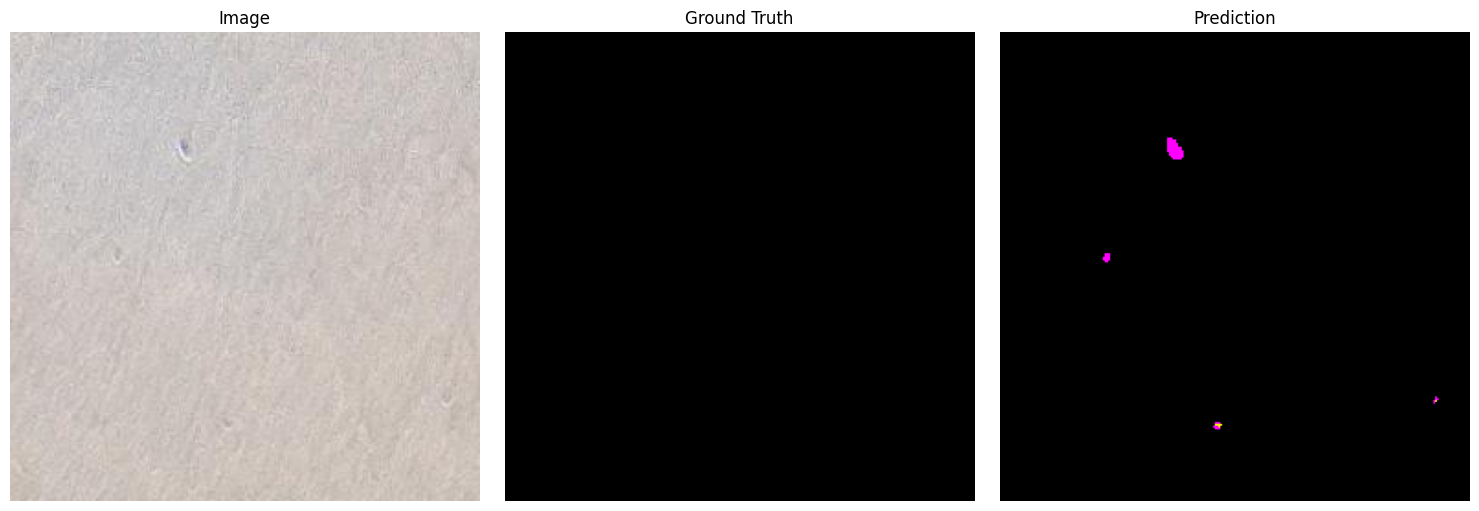

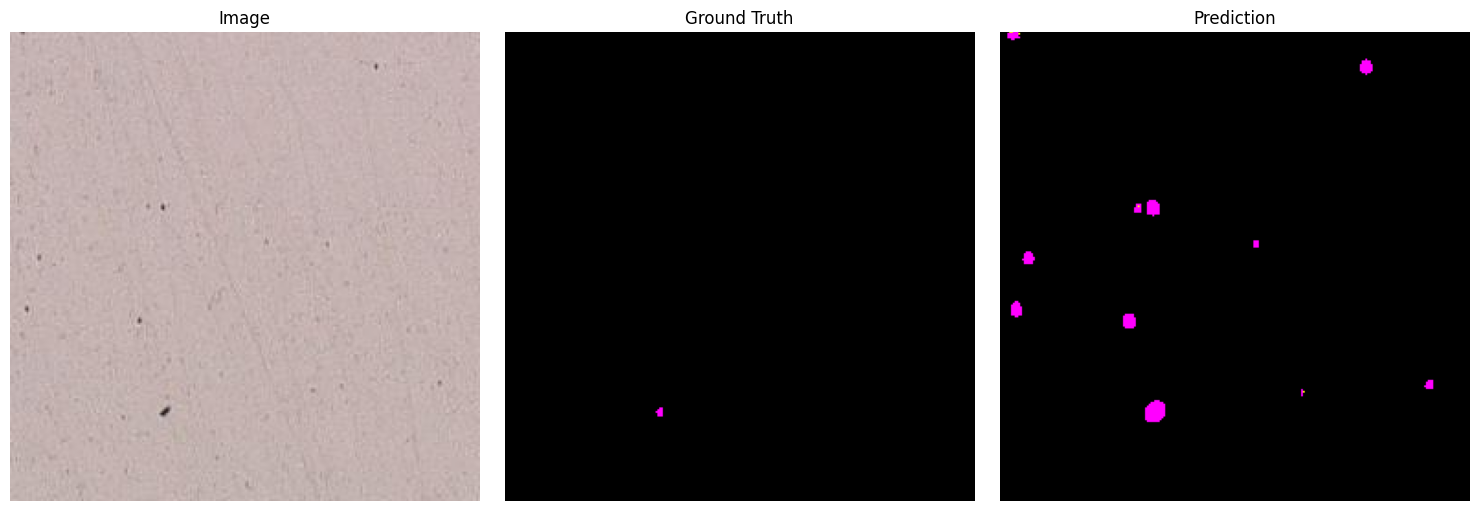

Evaluating:  27%|██▋       | 8/30 [00:19<00:59,  2.72s/it]

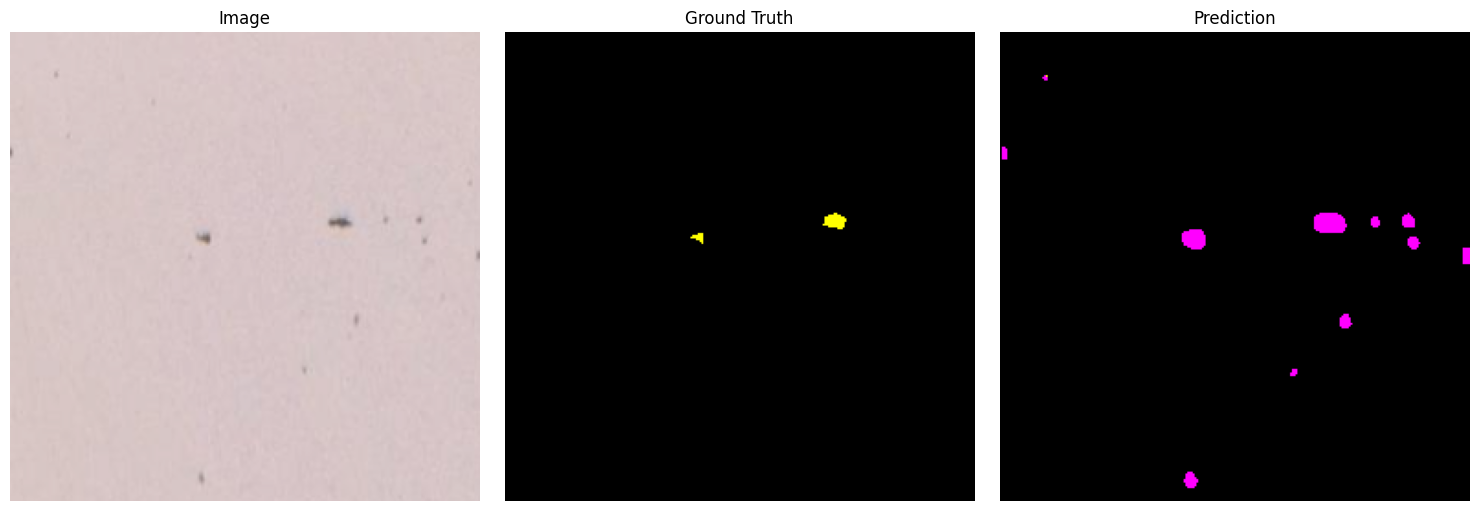

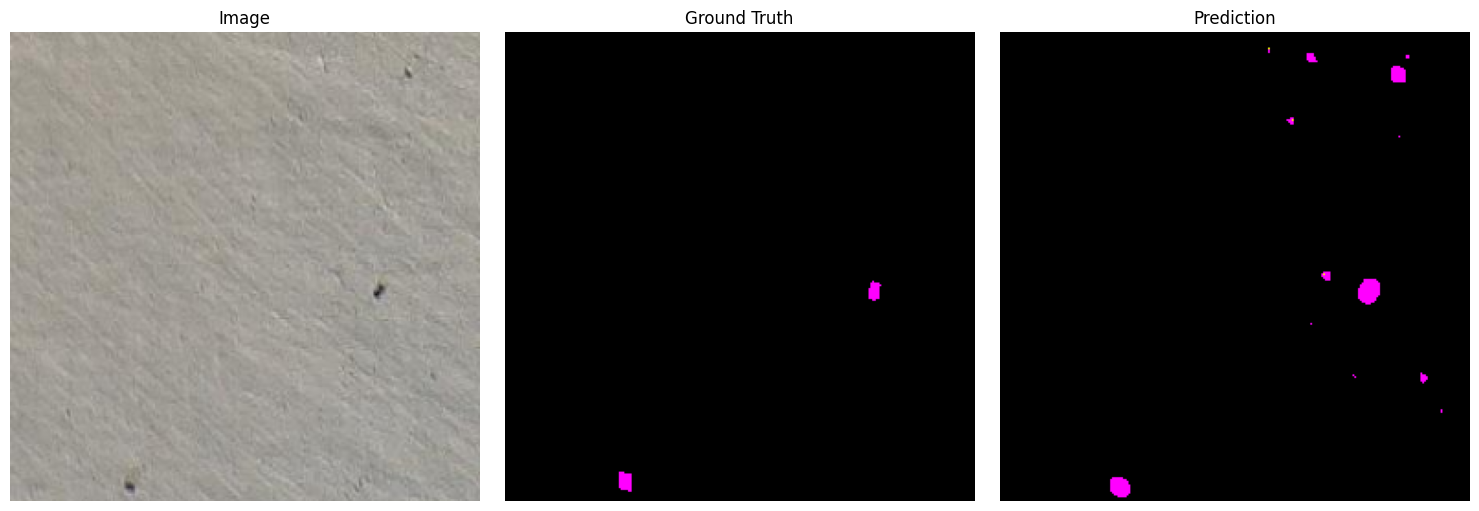

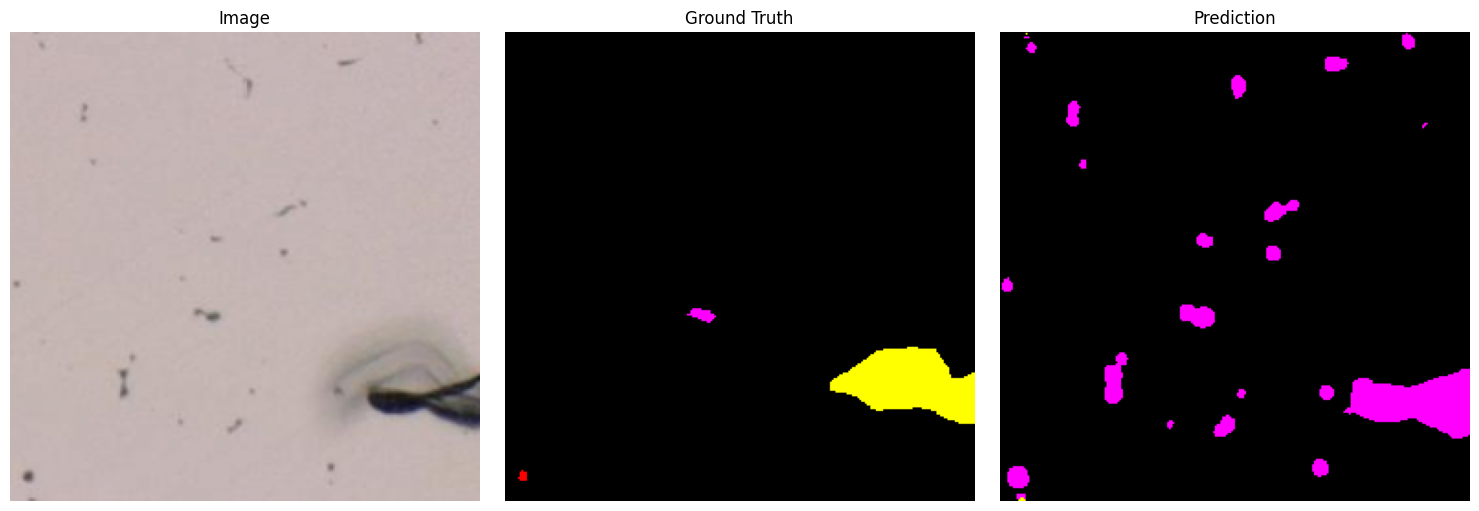

Evaluating: 100%|██████████| 30/30 [00:34<00:00,  1.16s/it]

Test mIoU: 0.399
Test Accuracy (including background): 0.826


In [240]:
evaluate(
    model_path='model.pt',
    test_loader=test_loader,
    device=device,
    patch=True,
    visualize=True,
    num_visuals=30,
    n_classes=11,
    class_colors=class_colors,
    save_dir='./visual_outputs'  # will save images here
)